In [1]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
#загружаем данные

df = pd.read_csv('bootstrap_dataset.csv')
df = df.drop(['Unnamed: 0'], axis=1)

In [3]:
df.head()

,experimentVariant,hits
0,Контрольная,68
1,Контрольная,45
2,Контрольная,66
3,Контрольная,29
4,Контрольная,39


In [4]:
df.experimentVariant.value_counts()

Новая          24974
Контрольная    24669
Name: experimentVariant, dtype: int64

In [5]:
#разделяем просмотры объявлений по группам

control = df[(df.experimentVariant == 'Контрольная')].hits.values
new = df[(df.experimentVariant == 'Новая')].hits.values

In [6]:
# посчитаем среднее в двух группах

print("Среднее количество просмотров объяв в КОНТРОЛЬНОЙ группе =", control.mean())
print("Среднее количество просмотров объяв в ТЕСТОВОЙ группе =", new.mean())

Среднее количество просмотров объяв в КОНТРОЛЬНОЙ группе = 11.41894685637845
Среднее количество просмотров объяв в ТЕСТОВОЙ группе = 11.785536958436774


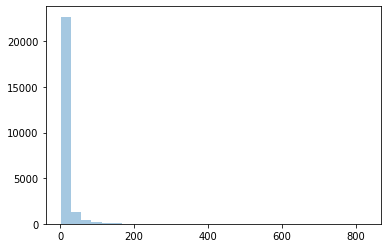

In [7]:
#посмотрим на распределение значений в двух группах

sns.distplot(control, kde=False, bins=30);

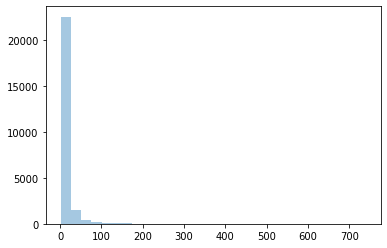

In [8]:
sns.distplot(new, kde=False, bins=30);

In [9]:
#применим критерий Манна-Уитни

stats.mannwhitneyu(control, new)

MannwhitneyuResult(statistic=304701935.5, pvalue=0.01726021207008357)

# Начнем визуализацию децилей

In [10]:
# считаем каждый дециль для обеих групп

deciles_control = []
deciles_new = []
DECILE_COUNT = 9

for i in range(DECILE_COUNT):
    deciles_control.append(np.quantile(control, 0.1*(i+1)))
    deciles_new.append(np.quantile(new, 0.1*(i+1)))

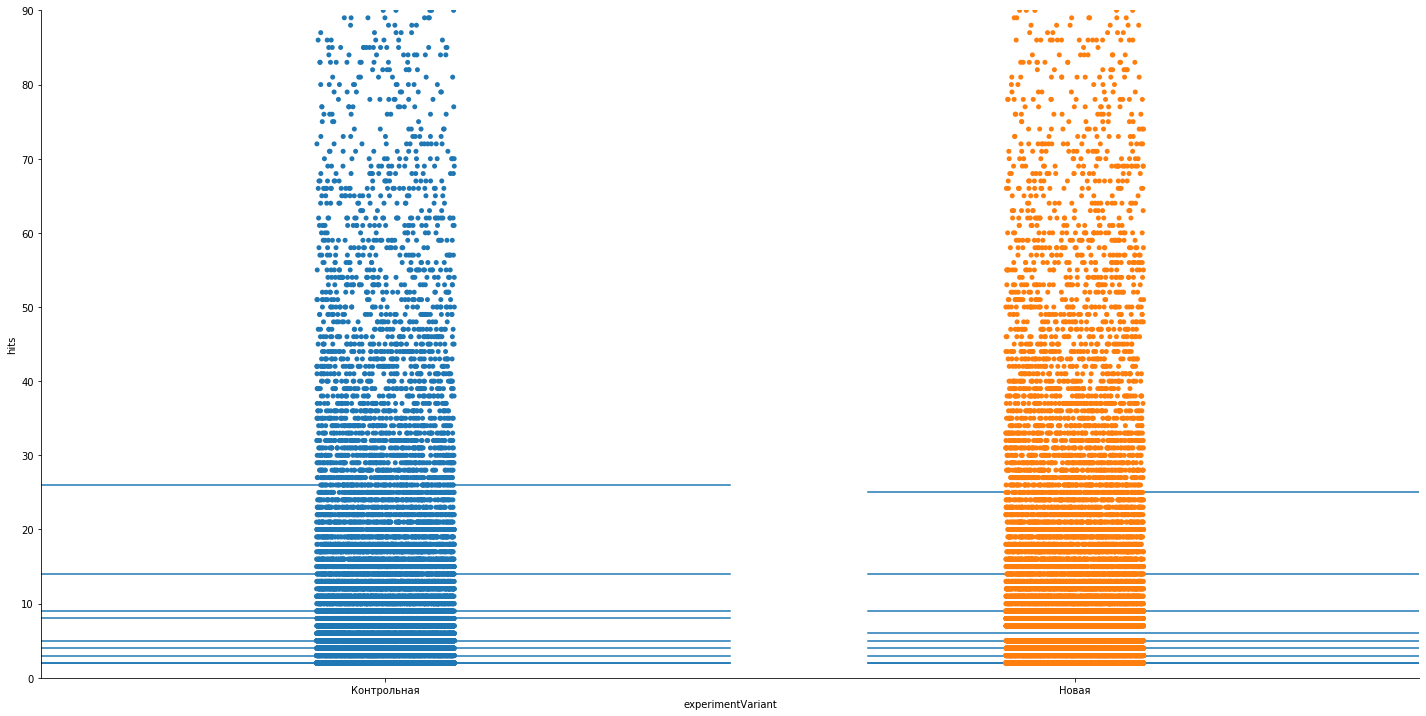

In [11]:
#визуализируем все на одном графике

ax = sns.catplot(x='experimentVariant', y='hits',  data=df, height=10, aspect=2)
ax.set(ylim=(0, 90))

for i in range(9):
    plt.axhline(deciles_control[i], 1, 0.6)
    plt.axhline(deciles_new[i], 0, 0.5)


# Функции для бутстрапа

In [12]:
# функция для генерации бутстрап-подвыборок

def get_bootstrap_samples(data, n_samples):
    N = len(data)
    indices = np.random.randint(0, N, (n_samples, N))
    samples = data[indices]
    return samples

In [13]:
# функция для расчета доверит. интервалов

def conf_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [14]:
# посмотрим, что будет на выходе у функции get_bootstrap_samples

print(get_bootstrap_samples(control, 1000))

[[ 13   5   5 ... 261  21  25]
 [  3  17   5 ...   2   3   6]
 [  3   3   5 ...   2   8   6]
 ...
 [  2   2   9 ...  18   3  38]
 [ 14   7   5 ...  13   2   5]
 [  2   3  15 ...   7   2   7]]


## Децильный анализ + бутстрап

In [15]:
# сортируем данные для правильного выделения децилей

control_sorted = np.array(sorted(control))
new_sorted = np.array(sorted(new))

In [16]:
len_c = len(control_sorted)   #длина массива по контрольной выборке
len_n = len(new_sorted)   #длина массива по новой выборке
bootstraped_means_diff = []

conf_int_0 = []
conf_int_1 = []

step_n = int(len_n/10)
step_c = int(len_c/10)


for i in range(10):
    # считаем начальные и конечные индексы для десятых долей сэмпла
    start_c = i*step_c
    end_c = start_c + step_c
    
    start_n = i*step_n
    end_n = start_n + step_n
    
    # выделяем десятые доли сэмпла
    deciles_data_c = control_sorted[start_c:end_c]
    deciles_data_n = new_sorted[start_n:end_n] 
    
    #ниже к каждой из долей применяется бутстрап
    np.random.seed(0)
    
    #в обеих группах в каждой из бутстрап-подвыборок считаем среднее, вместо среднего можно поставить любую из статистик
    #на выходе будет у каждой из групп будет map-object со средними  
    
    control_mean_scores = map(np.mean, get_bootstrap_samples(deciles_data_c, 1000))
    new_mean_scores = map(np.mean, get_bootstrap_samples(deciles_data_n, 1000))
    
    #считаем разницу между средними и для получившегося списка считаем доверит. интервал
    delta_mean_scores = list(map(lambda x: x[1]-x[0], zip(control_mean_scores, new_mean_scores)))   
    conf_int = conf_intervals(delta_mean_scores, 0.05)
    
    print(i+1,'-я часть сэмпла')
    print('95% доверительный интервал для разницы средних в бутстреп-выборках:', conf_int)


1 -я часть сэмпла
95% доверительный интервал для разницы средних в бутстреп-выборках: [0. 0.]
2 -я часть сэмпла
95% доверительный интервал для разницы средних в бутстреп-выборках: [0. 0.]
3 -я часть сэмпла
95% доверительный интервал для разницы средних в бутстреп-выборках: [-0.0693148  -0.01459536]
4 -я часть сэмпла
95% доверительный интервал для разницы средних в бутстреп-выборках: [-0.04459156 -0.01352958]
5 -я часть сэмпла
95% доверительный интервал для разницы средних в бутстреп-выборках: [-0.05787151 -0.01505827]
6 -я часть сэмпла
95% доверительный интервал для разницы средних в бутстреп-выборках: [0.41852624 0.51238368]
7 -я часть сэмпла
95% доверительный интервал для разницы средних в бутстреп-выборках: [1.01626088 1.08994971]
8 -я часть сэмпла
95% доверительный интервал для разницы средних в бутстреп-выборках: [0.01471795 0.17915069]
9 -я часть сэмпла
95% доверительный интервал для разницы средних в бутстреп-выборках: [0.41070154 0.76954093]
10 -я часть сэмпла
95% доверительный

# Для интереса попробуем нарисовать бутстреп-распределение средних в двух группах

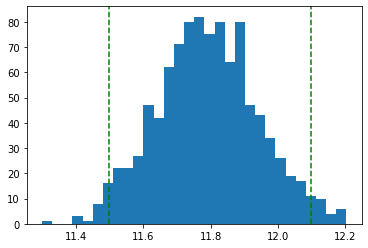

In [21]:
new_mean_scores = list(map(np.mean, get_bootstrap_samples(new, 1000)))
new_bounds = conf_intervals(new_mean_scores, 0.05)  #находим доверит интервалы

plt.hist(new_mean_scores, bins = 30, density = False)
# plt.axvline(x = new_mean, ymin = 0, ymax = 1, color ='red') 
plt.axvline(x = new_bounds[0], ymin = 0, ymax = 1, color ='green', linestyle ="--") 
plt.axvline(x = new_bounds[1], ymin = 0, ymax = 1, color ='green', linestyle ="--") 
plt.show()

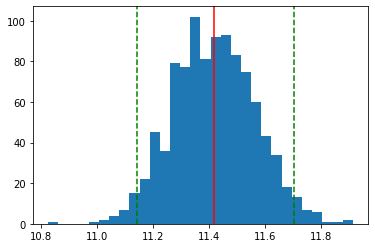

In [22]:
control_mean_scores = list(map(np.mean, get_bootstrap_samples(control, 1000)))
control_mean = np.mean(control_mean_scores)
new_bounds = conf_intervals(control_mean_scores, 0.05)

plt.hist(control_mean_scores, bins = 30, density = False)
plt.axvline(x = control_mean, ymin = 0, ymax = 1, color ='red') 
plt.axvline(x = new_bounds[0], ymin = 0, ymax = 1, color ='green', linestyle ="--") 
plt.axvline(x = new_bounds[1], ymin = 0, ymax = 1, color ='green', linestyle ="--") 
plt.show()

In [23]:
print(control_mean)

11.41831772670153
